## Le cartpole: un problème jouet

Nous allons implémenter l'algo présenter [ici](https://colab.research.google.com/drive/1249bhknPW1V5rq-bUyhixqp-yfbVHrTg#scrollTo=GTreo_TnMIJo) sur un problème jouet:  le cartpole.

### Aperçu

In [ ]:
%reset -f

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]

In [ ]:
import gym
from gym import logger as gymlogger
#from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start();

In [ ]:
env=gym.make('CartPole-v1')
env.reset()
img=env.render(mode='rgb_array')
plt.imshow(img);

* Un poteau (pole) est fixé par une articulation non actionnée à un chariot (cart), qui se déplace sur une piste sans frottement.
* Le système est contrôlé en poussant le chariot légèrement vers la gauche ou vers la droites (donc 2 actions possibles).
* Le pendule démarre à la verticale, et le but est de l'empêcher de tomber.
*  L'épisode se termine lorsque le poteau se trouve à plus de 15 degrés de la verticale, ou lorsque le chariot se déplace de plus de 2,4 unités par rapport au centre.
*  Dans l'environnement, une récompense de +1 est donnée tant que l'épisode n'est pas terminé, on modifiera un peu ce système de récompense.  


### Paramètres

In [ ]:
env=gym.make('CartPole-v1')
print("dimension des états:",env.observation_space.shape[0])
print("nombre d'action possibles:",env.action_space.n)

In [ ]:
print("état initial 1",env.reset())
print("état initial 2",env.reset())

`reset` met à l'état initial qui est aléatoire, mais à peu prêt à la verticale, sans trop de vitesse.

***A vous:*** Pourquoi ne démarre-t-on pas exactement vertical et immobile?

    [Cart Position from -4.8 to 4.8],
    [Cart Velocity from -Inf to Inf],
    [Pole Angle from -24° to 24°],
    [Pole Velocity At Tip from -Inf to Inf]

Observons ce qui se passe si l'on pousse toujours du même côté.

In [ ]:
def constant_action(action):
    env.reset()
    ss=[]
    done=False
    while not done:
        s,r,done,info=env.step(action)
        ss.append(s)
    env.close()
    return np.stack(ss)[:,0]

In [ ]:
positions_when_action_0=constant_action(0)
positions_when_action_1=constant_action(1)

In [ ]:
import numpy as np
plt.plot(range(len(positions_when_action_0)),positions_when_action_0,label="a=0")
plt.plot(range(len(positions_when_action_1)),positions_when_action_1,label="a=1")
plt.legend();

***A vous:*** L'action 0 cela fait aller à gauche ou à droite ? Pourquoi le mouvement s'accélère?



### Récompense

In [ ]:
def constant_action_r(action):
    env.reset()
    rs=[]
    dones=[]
    done=False
    while not done:
        s,r,done,info=env.step(action)
        rs.append(r)
        dones.append(done)
    env.close()
    return rs,dones

In [ ]:
recompenses=constant_action_r(0)
recompenses

***A vous:*** Faut-il garder les récompenses comme ceci ?

### Pas facile de garder le cartpole en l'air

In [ ]:
env=gym.make('CartPole-v1')
env.reset()

In [ ]:
img_shape=env.render(mode='rgb_array').shape
img_shape

Essayons de voir ce qui se passe en poussant un coup à gauche et un coup à droite.

In [ ]:
nb=500
imgs=np.empty((nb,)+img_shape,dtype=np.uint8)
for i in range(nb):
    env.step(i%2)
    imgs[i]=env.render(mode='rgb_array')

In [ ]:
fig,axs=plt.subplots(10,5,figsize=(20,20))
axs=axs.flatten()
axs.shape
for i in range(50):
    axs[i].imshow(imgs[i*10])
    axs[i].axis("off")

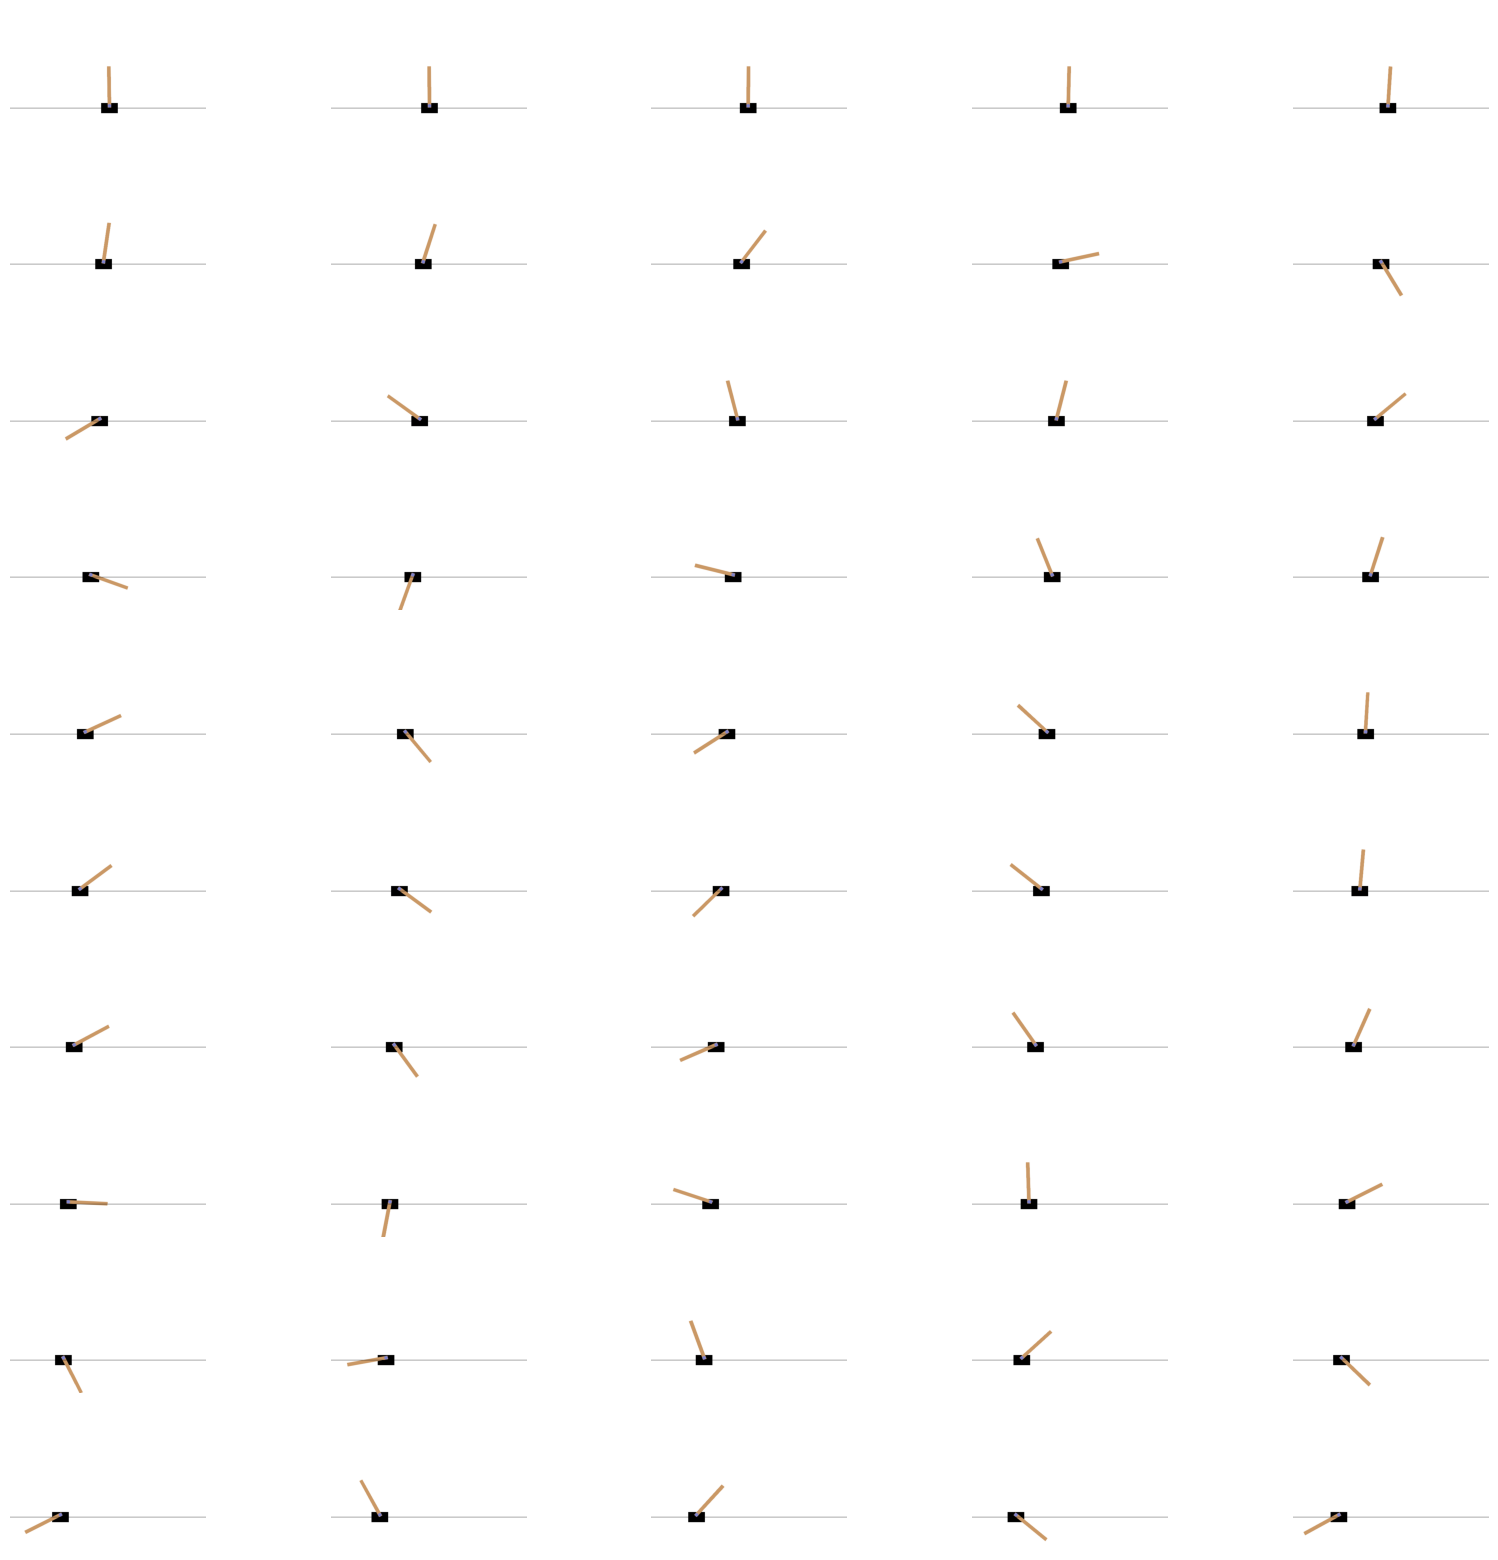

### Supervisé ou pas ?

Le  cartpole  fait-il parti des problèmes supervisé ou non supervisé

## Codons

### Import

In [ ]:
%reset -f

In [ ]:
import os
import random
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt


### L'agent

In [ ]:
class OurModel(torch.nn.Module):
    def __init__(self,space_dim,n_action):
        super().__init__()
        self.layer_0=torch.nn.Linear(space_dim,512)
        self.layer_1=torch.nn.Linear(512,256)
        self.layer_2=torch.nn.Linear(256,64)
        self.layer_3=torch.nn.Linear(64,n_action)

    def forward(self,X):
        S=torch.relu
        X=S(self.layer_0(X))
        X=S(self.layer_1(X))
        X=S(self.layer_2(X))
        X=self.layer_3(X)
        return X

Attention, l'équivalent de `np.max` c'est `torch.amax`

In [ ]:
print(torch.amax(torch.rand(5,5),dim=1))

In [ ]:
class DQNAgent:

    def __init__(self):
        self.env = gym.make('CartPole-v1')
        # by default, CartPole-v1 has max episode steps = 500
        self.state_dim = self.env.observation_space.shape[0]
        self.n_action = self.env.action_space.n
        self.EPISODES = 1000
        self.buffer_capacity=2000
        #self.train_start = self.buffer_capacity//2 #on commence l'entrainement quand le buffer est rempli à moitié


        self.buffer_counter = 0
        self.state_buffer = torch.zeros([self.buffer_capacity, self.state_dim])
        self.action_buffer = torch.zeros([self.buffer_capacity],dtype=torch.int64)
        self.reward_buffer = torch.zeros([self.buffer_capacity],dtype=torch.int64)
        self.next_state_buffer = torch.zeros([self.buffer_capacity, self.state_dim])
        self.done_buffer =torch.zeros([self.buffer_capacity],dtype=torch.bool)


        self.gamma = 0.95   # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.99
        self.batch_size = 64

        # create main model
        self.model = OurModel(self.state_dim,self.n_action)
        self.optimizer=torch.optim.Adam(self.model.parameters(),lr=1e-3)



        self.score_train=[]
        self.score_test=[]




    def record(self, s,a,r,s_,done):
        #ici on utilise des tableau torch pour le buffer. On pourrait aussi utiliser deque.
        # le modulo permet de remplacer les enregistremenets les plus anciens
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index,:] = s
        self.action_buffer[index] = a
        self.reward_buffer[index] = r
        self.next_state_buffer[index,:] = s_
        self.done_buffer[index]=done
        self.buffer_counter += 1

    #ici on définit l'epsilon stratégie
    def act(self, state):
        if np.random.random() <= self.epsilon:
            return torch.tensor(np.random.randint(self.n_action))
        else:
            return torch.argmax(self.model(state))


    def replay(self):

        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        s = self.state_buffer[batch_indices]
        a = self.action_buffer[batch_indices]
        r = self.reward_buffer[batch_indices]
        s_ = self.next_state_buffer[batch_indices]
        done=self.done_buffer [batch_indices]


        Q_s = self.model(s)
        Q_s_ = self.model(s_)

        #y  = r +    gamma  *  max_a' Q_w[s',a']
        #ou si done=True
        #y = r
        y=torch.where(done,r,r+self.gamma*torch.amax(Q_s_,dim=1))

        """
        on va calculer:
                        Q_s[i,a[i]]
        """
        Q_s_a = Q_s[torch.arange(self.batch_size) , a]
        loss=torch.mean((y-Q_s_a)**2)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()



    def env_step(self,action):
        #les rewards c'est que des 1, pas très intéressant
        next_state, _, done, _ = self.env.step(action.item())

        next_state=torch.tensor(next_state[None,:])
        return next_state,  done

    def env_initial_state(self):
        return torch.tensor(self.env.reset()[None,:])


    def run(self):

        for e in range(self.EPISODES):
            state = self.env_initial_state()
            done = False
            i = 0
            while not done:
                action = self.act(state)
                next_state, done = self.env_step(action)

                #on modifie le système de rewards
                if not done or i == 500:
                    reward = reward
                else:
                    reward = -100

                self.record(state, action, reward, next_state, done)
                state = next_state
                i += 1
            #FIN EPISODE

            if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay

            print(f"episode: {e}/{self.EPISODES}, score: {i}, eps: {self.epsilon:.3}")

            self.score_train.append(i)
            if i == 500:
                #print("Saving trained model as cartpole-dqn.h5")
                #torch.save(self.model.state_dict,"weights")
                return


            if self.buffer_counter > self.batch_size:
                for _ in range(10):
                    self.replay()


    def test(self):

        for e in range(100):
            state = self.env_initial_state()
            done = False
            i = 0
            while not done:
                action = torch.argmax(self.model(state))
                state, reward, done = self.env_step(action)

                i += 1
                if done:
                    print(f"episode: {e}/{self.EPISODES}, score: {i}")
                    self.score_test.append(i)
                    break

agent = DQNAgent()
agent.run()

In [ ]:
agent.test()

In [ ]:
plt.plot(agent.score_train)

In [ ]:
plt.plot(agent.score_test)

## Améliorations

### Double Deep-$Q$-learning (D2QN)



Dans l'algo précédent, le modèle $Q_w$ servait à choisir les actions d'exploration (avec proba $1-\epsilon$) et elle était aussi modifiée par l'exploration. Il peut s'en suivre certain "cercle vicieux": on aime un endroit, donc on y va, et on l'aime d'autant plus, donc on y revas etc.


Pour éviter cela on va utiliser on va utiliser 2 réseaux de neurones ayant la même architecture $Q_w$ et $Q_{\tilde w}$ mais des poids différents.




Dans l'algo, c'est essentiellement l'étape du replay qui change:

* On part de l'état $s$.
* On choisi une action $a$ suivant notre $\epsilon$-stratégie: avec proba $\epsilon$ on choisit un action au pif, avec proba $(1-\epsilon)$ on prend l'action qui maximise $Q_{w}$. Cela nous conduit à un état $s'$ et à une récompense $r$.  
* On stocke $(s,a,s',r)$ dans notre mémoire.  
* On tire un batch de $(s,a,s',r)$ dans notre mémoire. On modifie $w$ par back-propagation du gradient, pour miniser les distances entre:
$$
Q_{w}[s,a] \qquad \text{ et } \qquad     r + \gamma  \max_{a'} Q_{\tilde w}[ s',a']
$$
* on diminue $\epsilon$
* si $s'$ n'est pas terminal, on repart de la première étape avec $s\leftarrow s'$.
* sinon on actualise le réseau lent (=target): $\tilde w\leftarrow (1-\tau ) \tilde w + \tau w $ avec $\tau$ proche de 0 (ex: 0.1). Puis on repart d'un $s$ aléatoire.  






***Commentaires:***

 * $Q_{\tilde w}$ une version "rallentie" $Q_w$ dans le sens où les poids $\tilde w$ sont changés moins fréquement.
 * $Q_{\tilde w}$ est celui que l'on garde à la fin, c'est pour cela qu'on l'appelle souvent le "target" model
 * $Q_{w}$ sert à choisir les actions, quandis que $Q_{\tilde w}$ sert à les juger.

### File prioritaire

Lors du replay, au lieu de tirer les $(s,a,r,s')$ de manière uniforme, on peut en favoriser certain.

***A vous:*** Lesquels ?

### Référence


[toward data science](https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c)

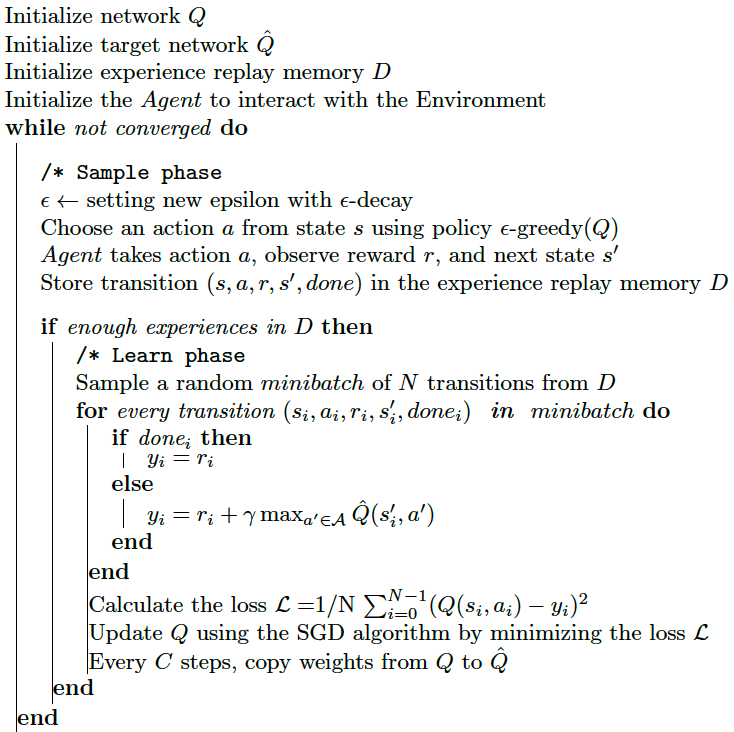